In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, accuracy_score, precision_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
from scipy.stats import ttest_rel, ttest_ind
from scipy import stats
import cms_preprocess

In [2]:
# Split the data into train and test sets
x_train, x_test, y_train, y_test = cms_preprocess.get_aov(ben_path=cms_preprocess.ben_path, ip_path=cms_preprocess.ip_path,
         pde_path=cms_preprocess.pde_path, dx_path=cms_preprocess.dx_path, pcs_path=cms_preprocess.pcs_path, ben_cols=cms_preprocess.ben_cols, ip_cols=cms_preprocess.ip_cols,
        pde_cols=cms_preprocess.pde_cols, start_year=2008, end_year=2010, random_state = 42, col_num=6)

/shared/orx/cms_preprocess.py:45: DtypeWarning: Columns (1,3,21) have mixed types. Specify dtype option on import or set low_memory=False.
  ben = pd.read_csv(ben_path, usecols=ben_cols)
/shared/orx/cms_preprocess.py:46: DtypeWarning: Columns (1,3,30) have mixed types. Specify dtype option on import or set low_memory=False.
  ip = pd.read_csv(ip_path, usecols=ip_cols)
/shared/orx/cms_preprocess.py:47: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  pde = pd.read_csv(pde_path, usecols=pde_cols)


(13688,)


Best threshold: 0.01
Fold 1: Train Loss=0.0003, Train Acc=1.0000, Val Loss=0.0001, Val Acc=1.0000
Best threshold: 0.01
Fold 2: Train Loss=0.0004, Train Acc=1.0000, Val Loss=0.0004, Val Acc=1.0000
Best threshold: 0.01
Fold 3: Train Loss=0.0004, Train Acc=1.0000, Val Loss=0.0004, Val Acc=1.0000
Best threshold: 0.01
Fold 4: Train Loss=0.0004, Train Acc=1.0000, Val Loss=0.0004, Val Acc=1.0000
Best threshold: 0.01
Fold 5: Train Loss=0.0004, Train Acc=1.0000, Val Loss=0.0008, Val Acc=1.0000
Train Loss: Mean=0.0004, Std=0.0000
Train Acc: Mean=1.0000, Std=0.0000
Val Loss: Mean=0.0004, Std=0.0002
Val Acc: Mean=1.0000, Std=0.0000


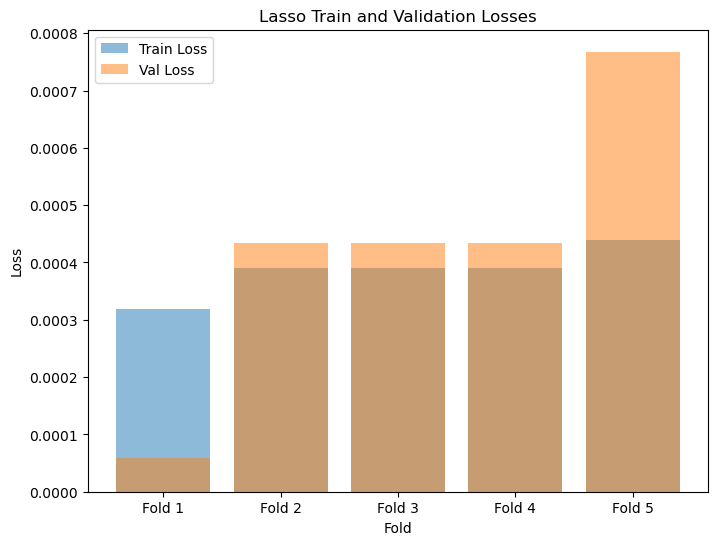

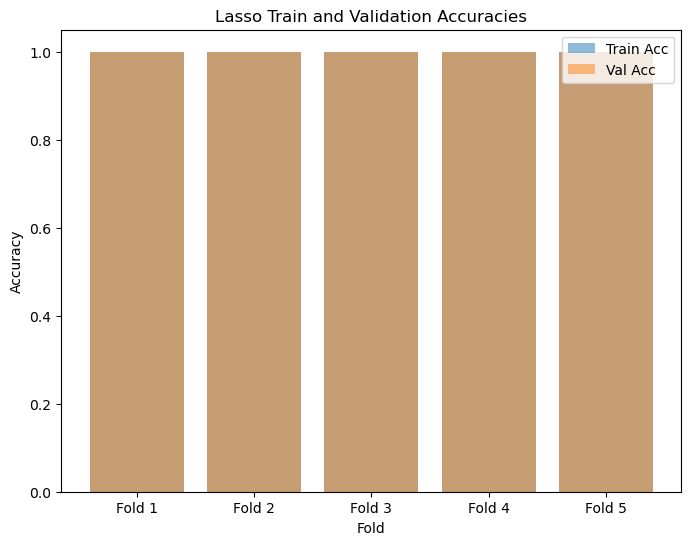

In [3]:
# Split the data into train and validation sets
x_t, x_val, y_t, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Initialize the Lasso classifier
clf = Lasso(alpha=0.001)

# 5-fold cross validation
train_losses = []
train_accs = []
val_losses = []
val_accs = []
for i, (train_idx, val_idx) in enumerate(KFold(n_splits=5, shuffle=True, random_state=42).split(x_t)):
    x_fold_train, y_fold_train = x_t[train_idx], y_t[train_idx]
    x_fold_val, y_fold_val = x_t[val_idx], y_t[val_idx]

    # Fit the classifier to the training data
    clf.fit(x_fold_train, y_fold_train)

    # Predict the target values on the training and validation sets
    y_train_pred = clf.predict(x_fold_train)
    y_val_pred = clf.predict(x_fold_val)

    # Find the F1 score for different threshold values
    preds = np.copy(y_train_pred)
    thresholds = np.arange(0, 1, 0.01)
    f1_scores = [f1_score(y_fold_train, (preds > t).astype(int), average='weighted') for t in thresholds]

    # Find the threshold value that maximizes the F1 score
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]

    print("Best threshold:" ,best_threshold)

    # Convert the continuous predictions to binary classes
    y_train_pred_binary = [1 if y > best_threshold else 0 for y in y_train_pred]
    y_val_pred_binary = [1 if y > best_threshold else 0 for y in y_val_pred]

    # Compute the loss and accuracy on the training set
    train_loss = np.mean(np.square(y_fold_train - y_train_pred))
    train_acc = accuracy_score(y_fold_train, y_train_pred_binary)

    # Compute the loss and accuracy on the validation set
    val_loss = np.mean(np.square(y_fold_val - y_val_pred))
    val_acc = accuracy_score(y_fold_val, y_val_pred_binary)

    print("Fold %d: Train Loss=%.4f, Train Acc=%.4f, Val Loss=%.4f, Val Acc=%.4f" % (i+1, train_loss, train_acc, val_loss, val_acc))

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

# Mean and standard deviation of the cross validation scores
print("Train Loss: Mean=%.4f, Std=%.4f" % (np.mean(train_losses), np.std(train_losses)))
print("Train Acc: Mean=%.4f, Std=%.4f" % (np.mean(train_accs), np.std(train_accs)))
print("Val Loss: Mean=%.4f, Std=%.4f" % (np.mean(val_losses), np.std(val_losses)))
print("Val Acc: Mean=%.4f, Std=%.4f" % (np.mean(val_accs), np.std(val_accs)))

# Set the x-axis labels
labels = [f"Fold {i+1}" for i in range(len(train_losses))]

# Plot train and validation losses as a bar plot
plt.figure(figsize=(8, 6))
plt.bar(labels, train_losses, label='Train Loss', alpha=0.5)
plt.bar(labels, val_losses, label='Val Loss', alpha=0.5)
plt.legend()
plt.title('Lasso Train and Validation Losses')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.show()

# Plot train and validation accuracies as a bar plot
plt.figure(figsize=(8, 6))
plt.bar(labels, train_accs, label='Train Acc', alpha=0.5)
plt.bar(labels, val_accs, label='Val Acc', alpha=0.5)
plt.legend()
plt.title('Lasso Train and Validation Accuracies')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.show()


# Fit the model to the training data
clf.fit(x_train, y_train)
train_pred = clf.predict(x_train)

# Predict the target values on the test set
y_pred = clf.predict(x_test)

Best threshold: 0.01


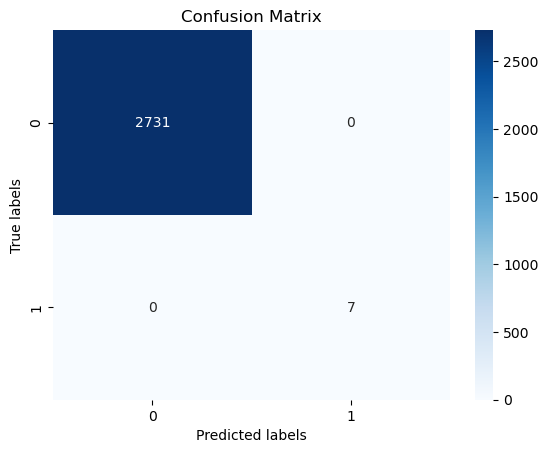

AUC: 1.0000
Precision with recall set to 0.9: 1.0000


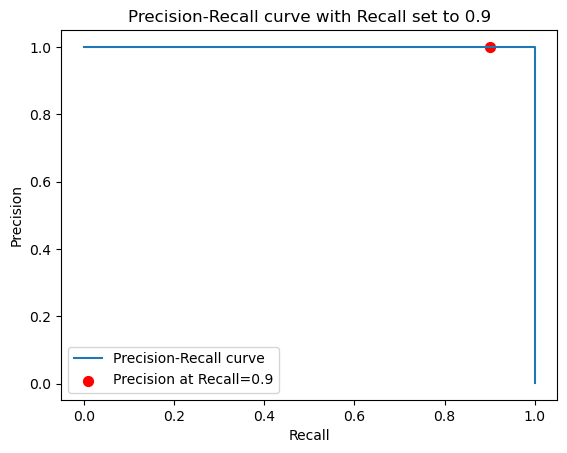

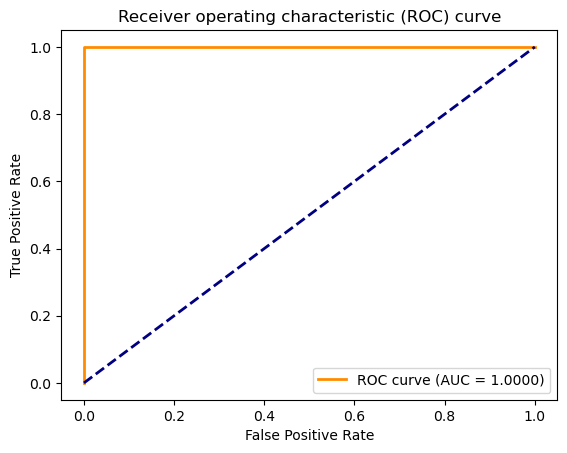

In [4]:
# Find the F1 score for different threshold values
train_preds = np.copy(train_pred)
thresholds = np.arange(0, 1, 0.01)
f1_scores = [f1_score(y_train, (train_preds > t).astype(int), average='weighted') for t in thresholds]

# Find the threshold value that maximizes the F1 score
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print("Best threshold:" ,best_threshold)

# Convert the continuous predictions to binary classes
preds = np.copy(y_pred)
y_test_pred_binary = [1 if y > best_threshold else 0 for y in preds]

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_pred_binary)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

# Add labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

# Compute the AUC
auc_score = roc_auc_score(y_test, y_test_pred_binary)
print("AUC: {:.4f}".format(auc_score))

# Compute the precision with recall set to 0.9
precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_binary)
precision_at_recall_09 = np.interp(0.9, recall[::-1], precision[::-1])
print("Precision with recall set to 0.9: {:.4f}".format(precision_at_recall_09))

# Plot the precision-recall curve with recall set to 0.9
plt.plot(recall, precision, label='Precision-Recall curve')
plt.scatter(0.9, precision_at_recall_09, s=50, color='red', label='Precision at Recall=0.9')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve with Recall set to 0.9')
plt.legend()
plt.show()

# Compute the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_binary)

# Compute the area under the curve (AUC)
roc_auc_curve = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.4f})'.format(roc_auc_curve))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc='lower right')
plt.show()

Fold 1: Train Loss=0.0025, Train Acc=0.9969, Val Loss=0.0014, Val Acc=0.9983
Fold 2: Train Loss=0.0022, Train Acc=0.9976, Val Loss=0.0045, Val Acc=0.9954
Fold 3: Train Loss=0.0021, Train Acc=0.9971, Val Loss=0.0022, Val Acc=0.9971
Fold 4: Train Loss=0.0025, Train Acc=0.9969, Val Loss=0.0014, Val Acc=0.9983
Fold 5: Train Loss=0.0020, Train Acc=0.9973, Val Loss=0.0028, Val Acc=0.9966
Train Loss: Mean=0.0023, Std=0.0002
Train Acc: Mean=0.9971, Std=0.0003
Val Loss: Mean=0.0025, Std=0.0011
Val Acc: Mean=0.9971, Std=0.0011


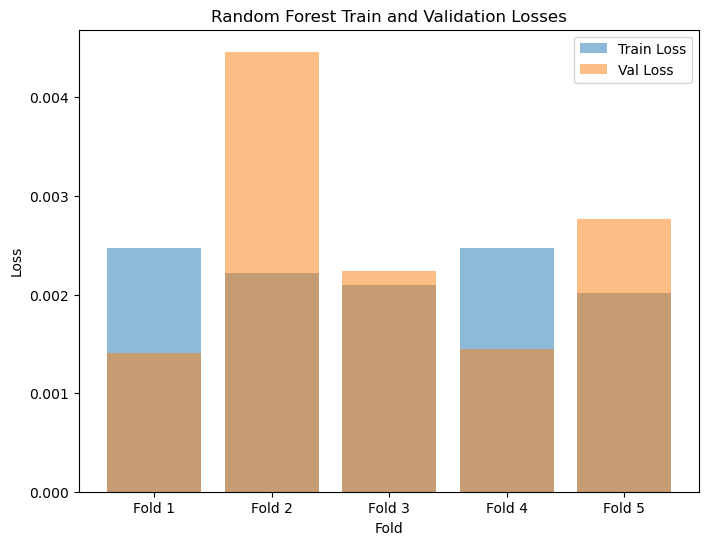

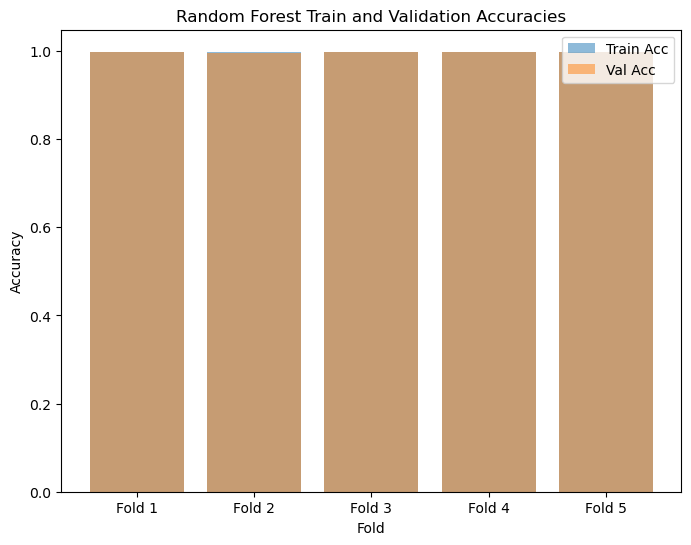

In [5]:
# Split the data into train and validation sets
x_t, x_val, y_t, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Initialize the Random Forest regressor
clf = RandomForestRegressor(n_estimators=100, max_depth=100, min_samples_split=10, min_samples_leaf=10, max_features='sqrt')

# 5-fold cross validation
train_losses = []
train_accs = []
val_losses = []
val_accs = []
for i, (train_idx, val_idx) in enumerate(KFold(n_splits=5, shuffle=True, random_state=42).split(x_t)):
    x_fold_train, y_fold_train = x_t[train_idx], y_t[train_idx]
    x_fold_val, y_fold_val = x_t[val_idx], y_t[val_idx]

    # Fit the regressor to the training data
    clf.fit(x_fold_train, y_fold_train)

    # Predict the target values on the training and validation sets
    y_train_pred = clf.predict(x_fold_train)
    y_val_pred = clf.predict(x_fold_val)

    # Compute the loss and accuracy on the training set
    train_loss = np.mean(np.square(y_fold_train - y_train_pred))
    train_acc = accuracy_score(y_fold_train, np.round(y_train_pred))

    # Compute the loss and accuracy on the validation set
    val_loss = np.mean(np.square(y_fold_val - y_val_pred))
    val_acc = accuracy_score(y_fold_val, np.round(y_val_pred))

    print("Fold %d: Train Loss=%.4f, Train Acc=%.4f, Val Loss=%.4f, Val Acc=%.4f" % (i+1, train_loss, train_acc, val_loss, val_acc))

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

# Mean and standard deviation of the cross validation scores
print("Train Loss: Mean=%.4f, Std=%.4f" % (np.mean(train_losses), np.std(train_losses)))
print("Train Acc: Mean=%.4f, Std=%.4f" % (np.mean(train_accs), np.std(train_accs)))
print("Val Loss: Mean=%.4f, Std=%.4f" % (np.mean(val_losses), np.std(val_losses)))
print("Val Acc: Mean=%.4f, Std=%.4f" % (np.mean(val_accs), np.std(val_accs)))

# Set the x-axis labels
labels = [f"Fold {i+1}" for i in range(len(train_losses))]

# Plot train and validation losses as a bar plot
plt.figure(figsize=(8, 6))
plt.bar(labels, train_losses, label='Train Loss', alpha=0.5)
plt.bar(labels, val_losses, label='Val Loss', alpha=0.5)
plt.legend()
plt.title('Random Forest Train and Validation Losses')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.show()

# Plot train and validation accuracies as a bar plot
plt.figure(figsize=(8, 6))
plt.bar(labels, train_accs, label='Train Acc', alpha=0.5)
plt.bar(labels, val_accs, label='Val Acc', alpha=0.5)
plt.legend()
plt.title('Random Forest Train and Validation Accuracies')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.show()

# Fit the model to the training data
clf.fit(x_train, y_train)
train_pred = clf.predict(x_train)

# Predict the target values on the test set
y_pred = clf.predict(x_test)

Best threshold: 0.02


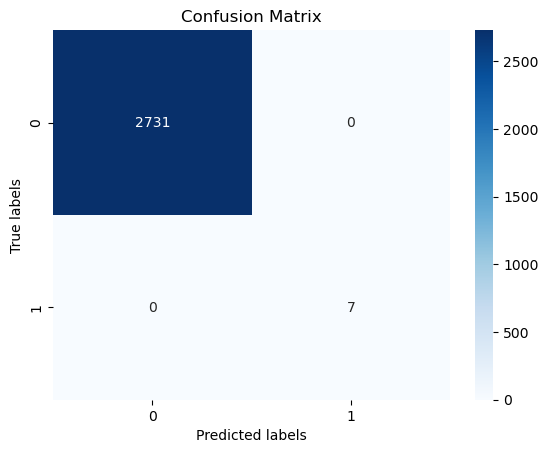

AUC: 1.0000
Precision with recall set to 0.9: 1.0000


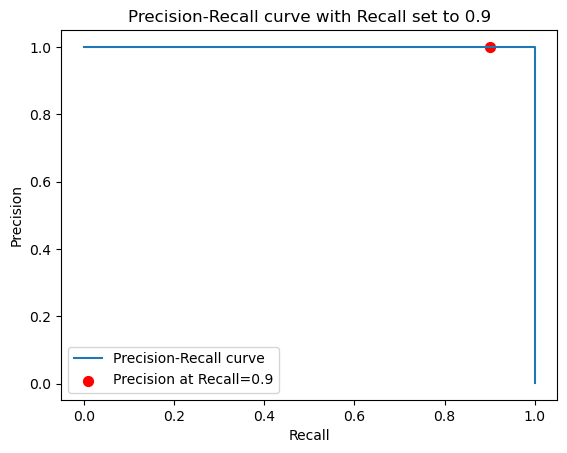

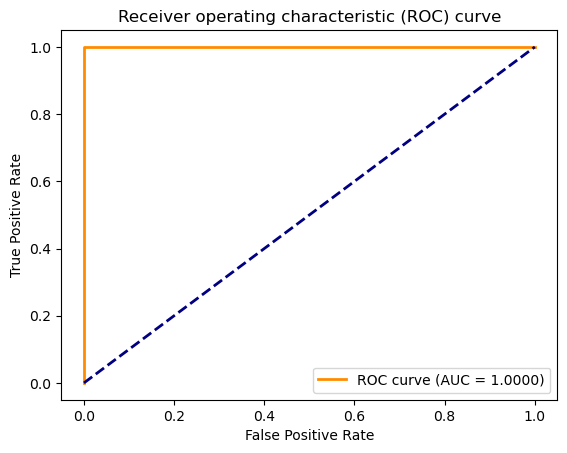

In [6]:
# Find the F1 score for different threshold values
train_preds = np.copy(train_pred)
thresholds = np.arange(0, 1, 0.01)
f1_scores = [f1_score(y_train, (train_preds > t).astype(int), average='weighted') for t in thresholds]

# Find the threshold value that maximizes the F1 score
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print("Best threshold:" ,best_threshold)

# Convert the continuous predictions to binary classes
preds = np.copy(y_pred)
y_test_pred_binary = [1 if y > best_threshold else 0 for y in preds]

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_pred_binary)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

# Add labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

# Compute the AUC
auc_score = roc_auc_score(y_test, y_test_pred_binary)
print("AUC: {:.4f}".format(auc_score))

# Compute the precision with recall set to 0.9
precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_binary)
precision_at_recall_09 = np.interp(0.9, recall[::-1], precision[::-1])
print("Precision with recall set to 0.9: {:.4f}".format(precision_at_recall_09))

# Plot the precision-recall curve with recall set to 0.9
plt.plot(recall, precision, label='Precision-Recall curve')
plt.scatter(0.9, precision_at_recall_09, s=50, color='red', label='Precision at Recall=0.9')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve with Recall set to 0.9')
plt.legend()
plt.show()

# Compute the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_binary)

# Compute the area under the curve (AUC)
roc_auc_curve = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.4f})'.format(roc_auc_curve))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc='lower right')
plt.show()

In [7]:
# Get the prediction for some samples in the test set
sample = x_test[np.where(y_test==1)[0]]

prediction = clf.predict(np.array(sample))

# Print the prediction
print('Prediction:', prediction)

Prediction: [0.07309609 0.07436151 0.07032381 0.08210981 0.08035714 0.06052505
 0.08139011]
